# HD correlation frequentistic recovery: Optimal Statistic results

In this notebook, we present the script to obtain the correlation between pulsars timing residuals and compare it with the Hellings Downs predictions. We used the **optimal statistic** (OS) tool, a frequentist estimator of the amplitude of the GWB that specifically looks for the spatial correlations between pulsars induced by the GWB. The 2023 updated version (contained in the python script *optimal_statistic_covariances.py*) of the OS allows to compute the average correlation in angular separation bins taking into account the covariance between the pulsar pairs (see [Allen & Romano 2023](https://arxiv.org/abs/2208.07230) for more details).

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import json

from enterprise.signals import signal_base
from enterprise.signals import gp_signals
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import white_signals
from enterprise_extensions import model_utils, blocks

from optimal_statistic_covariances import OptimalStatistic, get_HD_curve
#(source: https://gitlab.com/IPTA/ng_15yr_gwb_analysis_code)

Matplotlib created a temporary config/cache directory at /local/user/serena.valtolina/matplotlib-5hz9mk1o because the default path (/opt/pulsar/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# universe code: range 1001 - 1100
univ_code = '1002'
home_dir = './SMBHB_datasets/univ_'+univ_code+'/'

# definition of the psrs array from .par and .tim files

pulsar_list_dir = './pulsar_list.dat'
pulsar_names = np.loadtxt(pulsar_list_dir,dtype=str)

psrs = []
for name in pulsar_names[:]:
    par_dir = home_dir + 'parfiles/' + name + '.par'
    tim_dir = home_dir + 'tims/' + name + '.tim'
    psr = Pulsar(par_dir, tim_dir)
    psrs.append(psr)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
Npsrs = len(psrs)
n_pairs = int(Npsrs*(Npsrs-1)/2)
n_pp_bin = 30 # number of pulsar pairs in each bin
n_bins = int(n_pairs/n_pp_bin) # total number of bins

In [4]:
# noise Maximum Likelihood values dictionary
noise_ML_dir = './ml_params.json'
with open(noise_ML_dir, 'r') as f:
    noise_ML = json.load(f)
    f.close()

In [5]:
# ENTERPRISE recovery model def
#-------------------------------------------------------------------------


# find the maximum time span to set GW frequency sampling
tmin = [p.stoas.min() for p in psrs]
tmax = [p.stoas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

# fixing EFAC and EQUAD
efac = parameter.Constant(1.0) 
equad = parameter.Constant(-6)

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.TNEquadNoise(log10_tnequad = equad)

# timing model
tm = gp_signals.TimingModel() 

# GWB
gw = blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan, 
                                    components=9, gamma_val=4.33, name='gw')
# model base
model_base = tm + ef + eq + gw

In [6]:
def pulsar_model(psr, model_base):
    
    model = model_base
    
    # red noise
    if psr.name+'_red_noise_gamma' in noise_ML:
        log10_A = parameter.Uniform(-18,-11)
        gamma = parameter.Uniform(0,7)
        pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
        rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)
        model += rn
        
    # DM variations
    if psr.name+'_dm_gp_gamma' in noise_ML:
        log10_A_dm = parameter.Uniform(-18,-8)
        gamma_dm = parameter.Uniform(0, 7)
        pl_dm = utils.powerlaw(log10_A=log10_A_dm, gamma=gamma_dm)
        dm_basis = utils.createfourierdesignmatrix_dm(nmodes=100)
        dm = gp_signals.BasisGP(priorFunction=pl_dm, basisFunction=dm_basis, name='dm')
        model += dm
        
    return model(psr)

In [7]:
pta = signal_base.PTA([pulsar_model(psr,model_base) for psr in psrs])

In [8]:
# noise dictionary reading
noise_dict_dir = './white_noise_dict.json'
with open(noise_dict_dir, 'r') as fp:
    noise_dict = json.load(fp)
    fp.close()

# set the white noise parameters
pta.set_default_params(noise_dict)

In [9]:
# create object from NEW optimal statistic class
os_obj = OptimalStatistic(psrs, pta, noise_ML)

# Calculated "Traditional OS"
print(f"Traditional OS \nA^2 estimate: {os_obj.os()} +/- {os_obj.os_sigma()} with SNR: {os_obj.snr()}")

/enterprise/enterprise/signals/utils.py:885: RuntimeWarning: invalid value encountered in divide
  nmat = Mmat / norm


Traditional OS 
A^2 estimate: 1.0749262087888399e-29 +/- 2.1379541561378273e-30 with SNR: 5.027826278233548


In [10]:
covariance_matix_between_rhos = os_obj.gw_corr()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 45.33it/s]


In [11]:
# Get binned OS reconstruction with correlations
avg_angles, binned_os, bin_cov_matrix = os_obj.binned_os_with_correlations(nbins=10)
print(f"Num angles: {avg_angles.size}, Num bins: {binned_os.size}, cov matrix shape: {bin_cov_matrix.shape}")


Num angles: 10, Num bins: 10, cov matrix shape: (10, 10)


We can also estimate the expected cosmic variance for this specif set of pulsars. See [Allen & Romano 2023](https://arxiv.org/abs/2208.07230) for more details.

In [12]:
# confidence interval
#-----------------------------------------------------------------------

mu_bin = get_HD_curve(avg_angles) # normalization

C_inv = np.linalg.inv(covariance_matix_between_rhos)

mu_ab = get_HD_curve(os_obj.angles)

interval = mu_bin**2 / (np.dot(mu_ab,np.dot(C_inv,mu_ab)))
interval = np.sqrt(interval)

/work/serena.valtolina/PTA_realinj/A2.4/realinj_DR2final/tutorials/optimal_statistic_covariances.py:36: RuntimeWarning: divide by zero encountered in log
  HD = 3. * (1. / 3. + xip * (np.log(xip) - 1. / 6.))
/work/serena.valtolina/PTA_realinj/A2.4/realinj_DR2final/tutorials/optimal_statistic_covariances.py:36: RuntimeWarning: invalid value encountered in multiply
  HD = 3. * (1. / 3. + xip * (np.log(xip) - 1. / 6.))


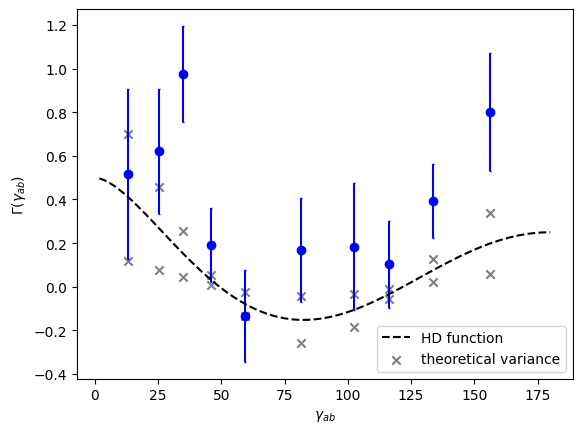

In [13]:
plt.errorbar(avg_angles*180/np.pi, binned_os/10**(2*noise_ML['gw_log10_A']), np.sqrt(np.diag(bin_cov_matrix))/10**(2*noise_ML['gw_log10_A']), capsize=1, color='blue', fmt='o')
angles = np.linspace(0, np.pi, num=100)
plt.plot(angles*180/np.pi, get_HD_curve(angles), c='k', ls='--', label='HD function')
plt.scatter(avg_angles*180/np.pi, get_HD_curve(avg_angles)+interval/10**(2*noise_ML['gw_log10_A']), color='grey', marker='x', label='theoretical variance')  
plt.scatter(avg_angles*180/np.pi, get_HD_curve(avg_angles)-interval/10**(2*noise_ML['gw_log10_A']), color='grey', marker='x')  

plt.legend(loc='best')
plt.xlabel('$\gamma_{ab}$')
plt.ylabel('$\Gamma(\gamma_{ab})$')
plt.show()

In [ ]:
# saving the results

import h5py
h5f = h5py.File(f'./SMBHB_datasets/univ_'+univ_code+'/OSfinal_10bin.h5', 'w')
h5f.create_dataset('/avg_angles', data=np.asarray(avg_angles) )
h5f.create_dataset('/binned_os', data=np.asarray(binned_os) )
h5f.create_dataset('/bin_cov_matrix', data=np.asarray(bin_cov_matrix) )
h5f.create_dataset('/interval', data=np.asarray(interval))
h5f.close()